In [1]:
import os, gc
import sys, pdb
import copy, time
import json, random
import time

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from pathlib import Path

import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
from colorama import Style, Fore
%matplotlib inline

In [2]:

import signal
import psutil
import itertools
import subprocess
import base64, gzip
import networkx as nx
import multiprocessing
#::::::::::::::::::::::::::::::::::::::::::::::
from numpy import array
from pathlib import Path
from scipy import ndimage
from scipy.stats import mode
from tqdm.auto import trange
from functools import partial
from tqdm.notebook import tqdm
from PIL import Image, ImageDraw
from xgboost import XGBClassifier
from itertools import combinations, product
from collections import defaultdict, Counter
from skimage.measure import label, regionprops
#::::::::::::::::::::::::::::::::::::::::::::::
from sklearn.tree import *
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from skimage.measure import label, regionprops
from sklearn.preprocessing import MinMaxScaler

from subprocess import Popen, PIPE, STDOUT
from glob import glob

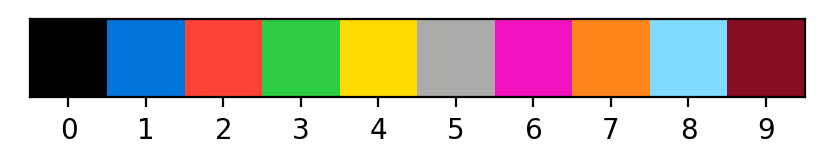

In [3]:
train1_path = '../input/arc-prize-2024/arc-agi_training_challenges.json'
train2_path = '../input/arc-prize-2024/arc-agi_training_solutions.json'

eval1_path = '../input/arc-prize-2024/arc-agi_evaluation_challenges.json'
eval2_path = '../input/arc-prize-2024/arc-agi_evaluation_solutions.json'

test_path = '../input/arc-prize-2024/arc-agi_test_challenges.json'
sample_path = '../input/arc-prize-2024/sample_submission.json'

# ......................................................................................................
cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])

norm = colors.Normalize(vmin=0, vmax=9)
color_list = ["black", "blue", "red", "green", "yellow", "gray", "magenta", "orange", "sky", "brown"]

# ......................................................................................................
plt.figure(figsize=(5, 2), dpi=200)
plt.imshow([list(range(10))], cmap=cmap, norm=norm)
plt.xticks(list(range(10)))
plt.yticks([])
plt.show()

In [7]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
def plot_pic(x):
    plt.imshow(np.array(x), cmap=cmap, norm=norm)
    plt.show()
    
# ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
def plot_data(task):
    n = len(task["train"]) + len(task["test"])
    fig, axs = plt.subplots(2, n, figsize=(4*n,8), dpi=200)
    plt.subplots_adjust(wspace=0, hspace=0)
    fig_num = 0
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Train-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Train-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    for i, t in enumerate(task["test"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Test-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Test-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    
    plt.tight_layout()
    plt.show()
    
# ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
def plot_task(task):
    n = len(task["train"]) + len(task["test"])
    fig, axs = plt.subplots(2, n, figsize=(4*n,8), dpi=200)
    plt.subplots_adjust(wspace=0, hspace=0)
    fig_num = 0
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Train-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Train-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    for i, t in enumerate(task["test"]):
        t_in = np.array(t["input"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Test-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        fig_num += 1
    
    plt.tight_layout()
    plt.show()  
    
# ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::


In [8]:
train1_icecube_out = 'absres-c-files/train_submission_part.csv'
test_icecube_out = 'absres-c-files/test_submission_part.csv'
eval1_icecube_out = 'absres-c-files/evaluation_submission_part.csv'

# Function to translate from old submission format (csv) to new one (json)
def translate_submission(file_path):
    # Read the original submission file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    submission_dict = {}

    for line in lines[1:]:  # Skip the header line
        output_id, output = line.strip().split(',')
        task_id, output_idx = output_id.split('_')
        predictions = output.split(' ')  # Split predictions based on ' '
        
        # Take only the first two predictions
        if len(predictions) > 2:
            predictions = predictions[:2]

        processed_predictions = []
        for pred in predictions:
            if pred:  # Check if pred is not an empty string
                pred_lines = pred.split('|')[1:-1]  # Remove empty strings from split
                pred_matrix = [list(map(int, line)) for line in pred_lines]
                processed_predictions.append(pred_matrix)

        attempt_1 = processed_predictions[0] if len(processed_predictions) > 0 else []
        attempt_2 = processed_predictions[1] if len(processed_predictions) > 1 else []

        if task_id not in submission_dict:
            submission_dict[task_id] = []

        attempt_dict = {
            "attempt_1": attempt_1,
            "attempt_2": attempt_2
        }

        if output_idx == '0':
            submission_dict[task_id].insert(0, attempt_dict)
        else:
            submission_dict[task_id].append(attempt_dict)
    
    # Write to the new json file
    with open('sub_icecube.json', 'w') as file:
        json.dump(submission_dict, file, indent=4)

22168020


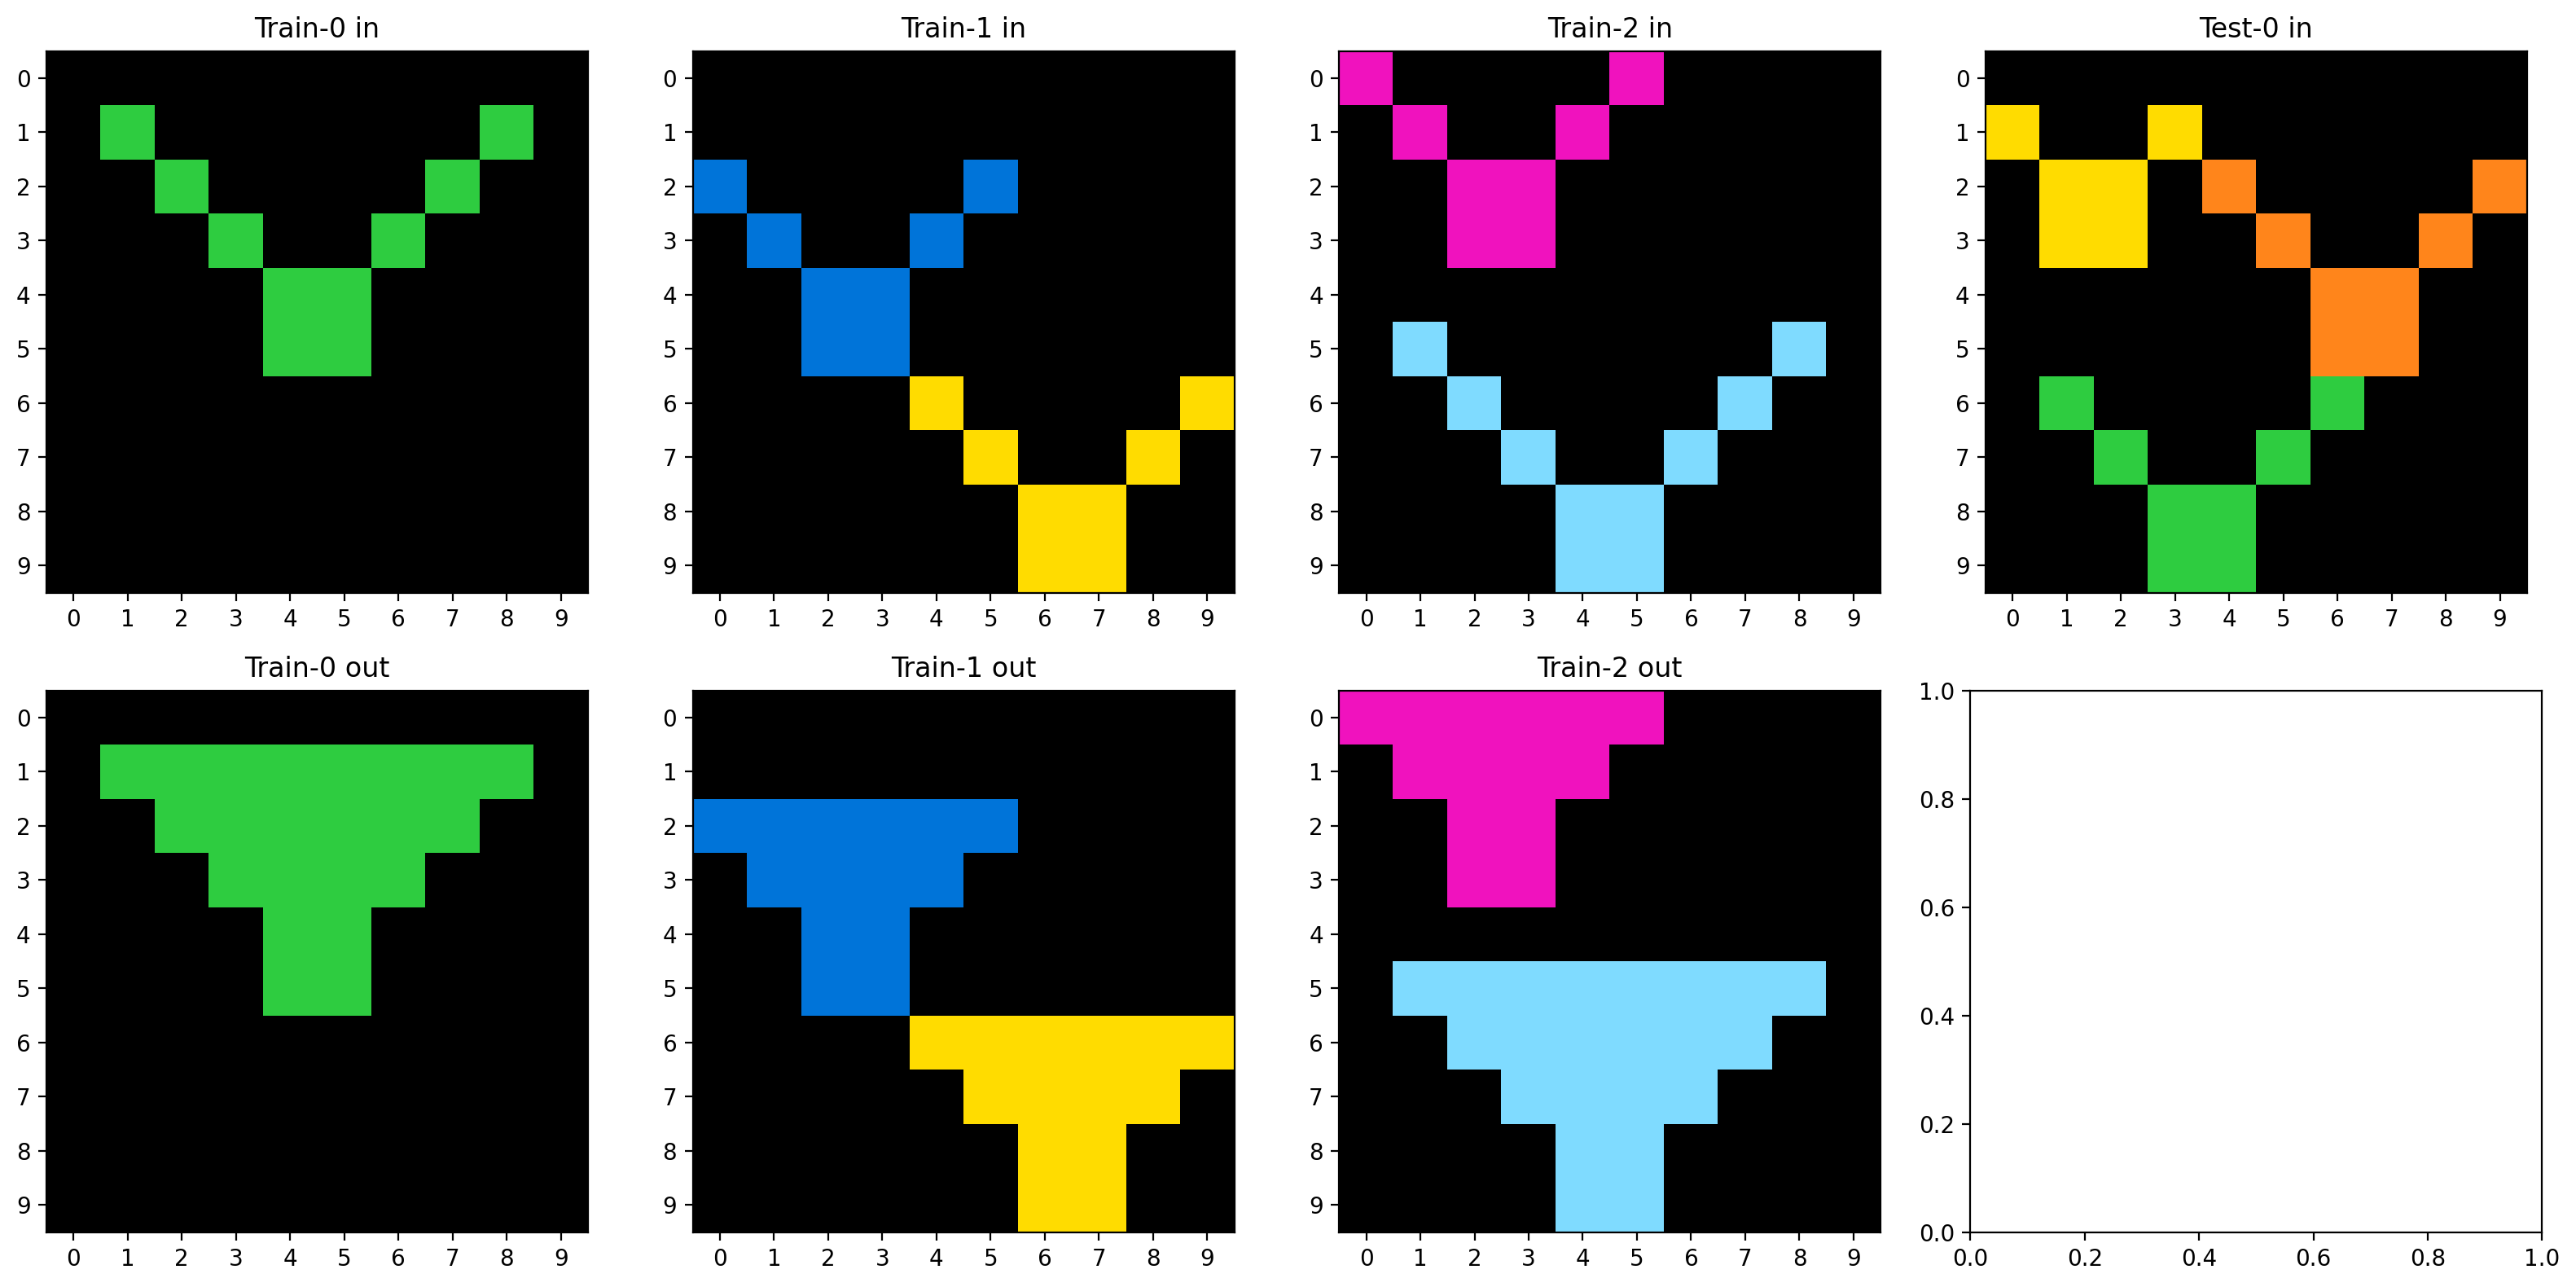

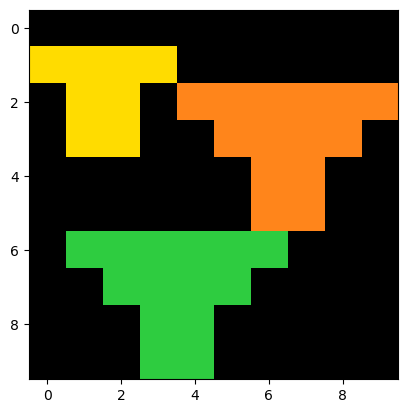

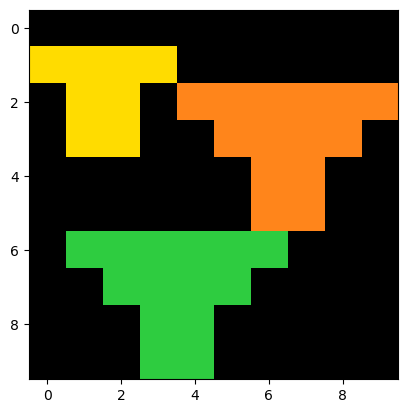

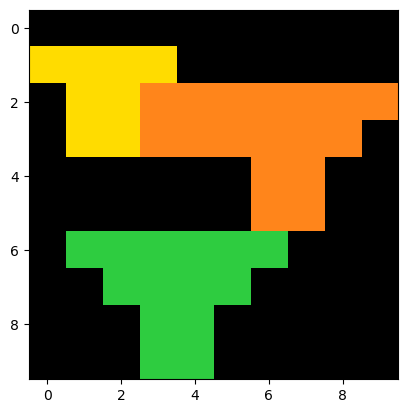

In [25]:
def run_check(data_path, icecube_output_path, true_output_path=None): 
    
    translate_submission(icecube_output_path)
    with open('./sub_icecube.json' , 'r') as f:
        sub_icecube = json.load(f)
    
    with open(data_path,'r') as f:
        tasks_name = list(json.load(f).keys())
    
    with open(data_path,'r') as f:
        tasks_file = list(json.load(f).values())
        
    if true_output_path is not None:
        with open(true_output_path,'r') as f:
            true_tasks_file = json.load(f)
    
    # ...............................................................................
    for n in range(len(tasks_name)):
        task = tasks_file[n]
        t = tasks_name[n]
        
        print(t)
        for i in range(len(task['test'])): 
            test_input = np.array(task['test'][i]['input'])
            prn = []
            plot_task(task)
            
            # plot true output
            if true_output_path is not None:
                plot_pic(true_tasks_file[t][i])
            
            # # plot icecube output
            plot_pic(sub_icecube[t][i]['attempt_1'])
            plot_pic(sub_icecube[t][i]['attempt_2'])
        break
    
run_check(train1_path, train1_icecube_out, train2_path)

In [81]:
def run_check(data_path, icecube_output_path, true_output_path): 
    deep_equal = np.vectorize(np.array_equal)
    def inner_array_equal(a,b): 
        import traceback
        try:
            result = np.all(deep_equal(a,b))
        except:
            result = False
            # traceback.print_exc()
        return result
    
    translate_submission(icecube_output_path)
    with open('./sub_icecube.json' , 'r') as f:
        sub_icecube = json.load(f)
    
    with open(data_path,'r') as f:
        tasks_name = list(json.load(f).keys())
    
    with open(data_path,'r') as f:
        tasks_file = list(json.load(f).values())
        
    if true_output_path is not None:
        with open(true_output_path,'r') as f:
            true_tasks_file = json.load(f)
    
    attempt1_count = 0
    attempt2_count = 0
    total_task = 0
    only1_correct = 0
    only2_correct = 0
    both_correct = 0
    none_correct = 0
    failed_count = 0
    failed_list = []
    
    # ...............................................................................
    for n in range(len(tasks_name)):
        task = tasks_file[n]
        t = tasks_name[n]
        
        # print(t)
        for i in range(len(task['test'])): 
            
            test_input = np.array(task['test'][i]['input'])
            prn = []
            # plot_task(task)
            
            # # plot true output
            # if true_output_path is not None:
            #     plot_pic(true_tasks_file[t][i])
            
            # # # plot icecube output
            # plot_pic(sub_icecube[t][i]['attempt_1'])
            # plot_pic(sub_icecube[t][i]['attempt_2'])
            
            true_pattern = true_tasks_file[t][i]
            
            if t in sub_icecube:
                ice_cube_output1 = sub_icecube[t][i]['attempt_1']
                ice_cube_output2 = sub_icecube[t][i]['attempt_2']
            else:
                ice_cube_output1 = np.array([[0, 0], [0, 0]], dtype=np.float64)
                ice_cube_output2 = np.array([[0, 0], [0, 0]], dtype=np.float64)
                
                failed_count += 1
                failed_list.append(n)
                
                continue
                
            total_task += 1
            true1 = int(inner_array_equal(true_pattern, ice_cube_output1))
            attempt1_count += true1
                
            true2 = int(inner_array_equal(true_pattern, ice_cube_output2))
            attempt2_count += true2
                
            if true1 and not true2:
                only1_correct += 1
                
            if true2 and not true1:
                only2_correct += 1
                
            if true2 and true1:
                both_correct += 1
            
            if not true1 and not true2:
                none_correct += 1
                # plot_task(task)
                
                # # plot true output
                # if true_output_path is not None:
                #     plot_pic(true_tasks_file[t][i])
                
                # # # plot icecube output
                # plot_pic(sub_icecube[t][i]['attempt_1'])
                # plot_pic(sub_icecube[t][i]['attempt_2'])
                
                                
    print(f"total_task (not included failed) {total_task}")
    print(f"attempt1_count {attempt1_count}")
    print(f"attempt2_count {attempt2_count}")
    print(f"only1_correct {only1_correct}")
    print(f"only2_correct {only2_correct}")
    print(f"both_correct {both_correct}")
    print(f"none_correct {none_correct}")
    print(f"failed_count {failed_count}")
    print("failed_list", failed_list)
    
run_check(train1_path, train1_icecube_out, train2_path)

total_task (not included failed) 399
attempt1_count 184
attempt2_count 22
only1_correct 184
only2_correct 22
both_correct 0
none_correct 193
failed_count 17
failed_list [56, 56, 64, 64, 64, 108, 108, 120, 181, 246, 290, 338, 345, 354, 390, 392, 393]


In [64]:
from solver_7 import predict_repeating, check_sub_grid_2x, check_repeating, check_grid, predict_transforms_grid_2x, \
    check_chess, predict_chess, grid_filter, check_tiles_shape, predict_tiles_shape, check_grid_transforms, predict_grid_transforms, \
        check_sub_mask, predict_repeating_mask, check_subitem
from tree import format_features, make_features, tree1
from color_counter import Create, colors_counter
from sym_repairing import symmetry_repairing

In [65]:
# ..................................................................................... 1
def ganswer_answer(ganswer):
    
    answer = []
    for j in range(len(ganswer)):
        ganswer_j = ganswer[j].tolist()
        
        if (ganswer_j not in answer):  
            answer.append(ganswer_j)   
            
    return answer

# ..................................................................................... 2
def ganswer_answer_1(ganswer):
    
    answer = []
    for j in range(len(ganswer)):
        ganswer_j = ganswer[j]
        
        if (ganswer_j not in answer):  
            answer.append(ganswer_j)   
            
    return answer

# ..................................................................................... 3
def prn_plus(prn, answer):
    
    for j in range(len(answer)):
        prn = prn + [answer[j]]  
        
        if (j == 0):
            prn = prn + [answer[j]]
            
    return prn

# ..................................................................................... 4
def prn_select_2(prn): 
    if (len(prn) > 2):
        
        value_list = []
        string_list = []
        for el in prn:
            value = 0
            for i in range(len(prn)):
                if el == prn[i]:
                    value +=1
            value_list.append(value)
            string_list.append(str(el))    
        
        prn_df  = pd.DataFrame({'prn': prn , 'value': value_list, 'string': string_list}) 
        prn_df1 = prn_df.drop_duplicates(subset=['string'])
        prn_df2 = prn_df1.sort_values(by='value', ascending=False)   
        
        prn = prn_df2['prn'].values.tolist()[:2]
        
    return prn

# ..................................................................................... 5
cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])

norm = colors.Normalize(vmin=0, vmax=9)
color_list = ["black", "blue", "red", "green", "yellow", "gray", "magenta", "orange", "sky", "brown"]

def plot_pic(x):
    plt.imshow(np.array(x), cmap=cmap, norm=norm)
    plt.show()
    

dict_keys(['007bbfb7', '00d62c1b', '017c7c7b', '025d127b', '045e512c', '0520fde7', '05269061', '05f2a901', '06df4c85', '08ed6ac7', '09629e4f', '0962bcdd', '0a938d79', '0b148d64', '0ca9ddb6', '0d3d703e', '0dfd9992', '0e206a2e', '10fcaaa3', '11852cab', '1190e5a7', '137eaa0f', '150deff5', '178fcbfb', '1a07d186', '1b2d62fb', '1b60fb0c', '1bfc4729', '1c786137', '1caeab9d', '1cf80156', '1e0a9b12', '1e32b0e9', '1f0c79e5', '1f642eb9', '1f85a75f', '1f876c06', '1fad071e', '2013d3e2', '2204b7a8', '22168020', '22233c11', '2281f1f4', '228f6490', '22eb0ac0', '234bbc79', '23581191', '239be575', '23b5c85d', '253bf280', '25d487eb', '25d8a9c8', '25ff71a9', '264363fd', '272f95fa', '27a28665', '28bf18c6', '28e73c20', '29623171', '29c11459', '29ec7d0e', '2bcee788', '2bee17df', '2c608aff', '2dc579da', '2dd70a9a', '2dee498d', '31aa019c', '321b1fc6', '32597951', '3345333e', '3428a4f5', '3618c87e', '3631a71a', '363442ee', '36d67576', '36fdfd69', '3906de3d', '39a8645d', '39e1d7f9', '3aa6fb7a', '3ac3eb23', '3af2

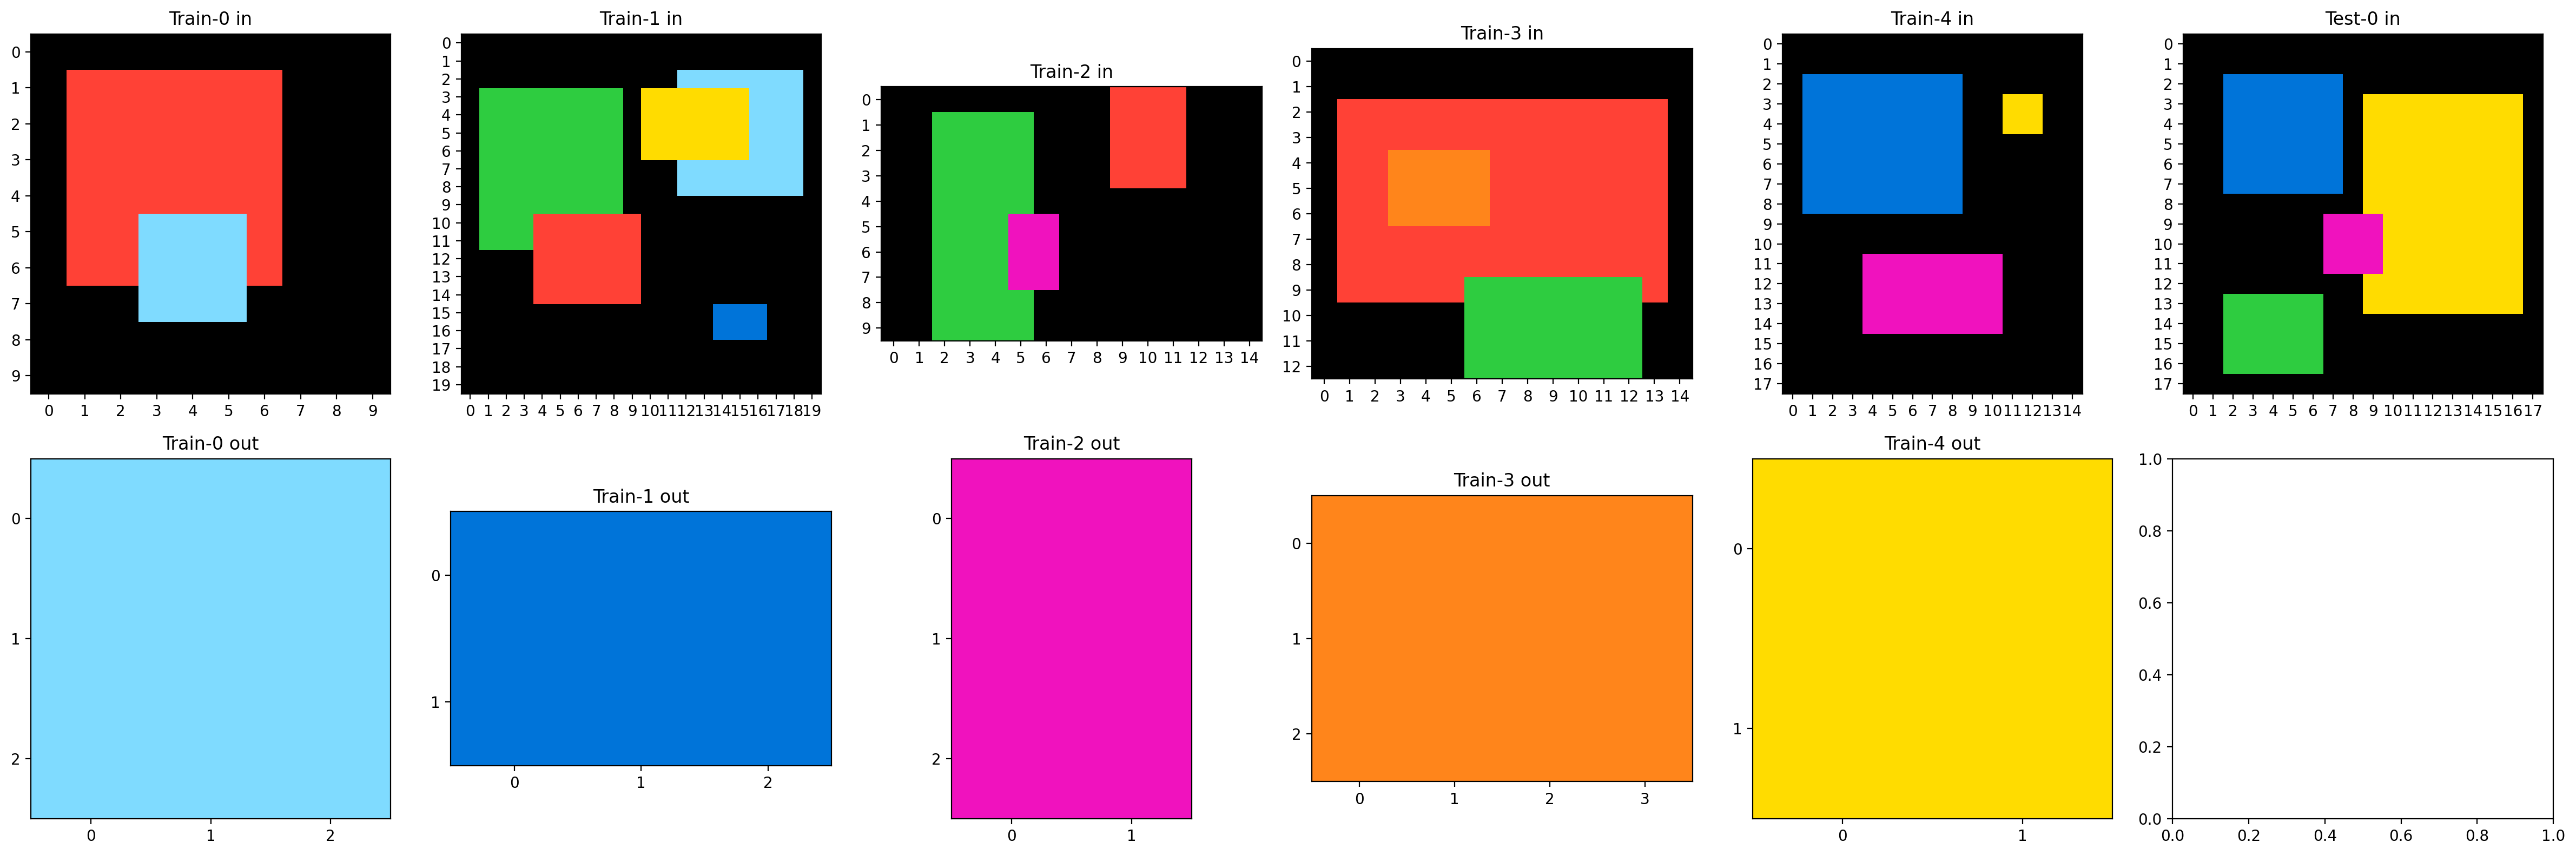

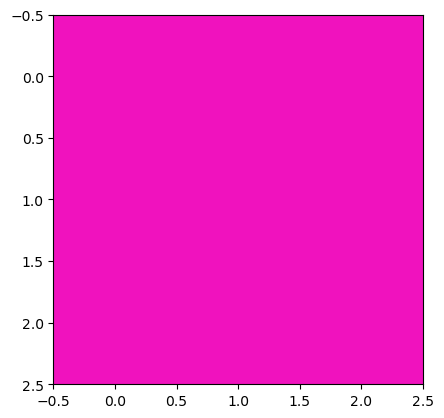

In [84]:
def run_main_solvers(data_path, sample_path, true_output_path): 
    deep_equal = np.vectorize(np.array_equal)
    def inner_array_equal(a,b): 
        import traceback
        try:
            result = np.all(deep_equal(a,b))
        except:
            result = False
            # traceback.print_exc()
        return result

    with open(sample_path,'r') as f:
        sub_solver = json.load(f) 
        
    # ...............................................................................
    with open(data_path,'r') as f:
        tasks_name = list(json.load(f).keys())
    
    with open(data_path,'r') as f:
        tasks_file = list(json.load(f).values())
        
    if true_output_path is not None:
        with open(true_output_path,'r') as f:
            true_tasks_file = json.load(f)
            
    print(sub_solver.keys())
    
    # ...............................................................................
    for n in range(56, len(tasks_file)):
        if n in [56, 56, 64, 64, 64, 108, 108, 120, 181, 246, 290, 338, 345, 354, 390, 392, 393]:
            continue
        task = tasks_file[n]
        t = tasks_name[n]
        # if t != "27a28665":
        #     continue
        print(n)

        for i in range(len(task['test'])): 
            test_input = np.array(task['test'][i]['input'])
            prn = []
            plot_task(task)
            
            # plot true output
            if true_output_path is not None:
                plot_pic(true_tasks_file[t][i])
        break
            
            
run_main_solvers(train1_path, sample_path, train2_path)

In [93]:
def run_main_solvers(data_path, sample_path, true_output_path): 
    deep_equal = np.vectorize(np.array_equal)
    def inner_array_equal(a,b): 
        import traceback
        try:
            result = np.all(deep_equal(a,b))
        except:
            result = False
            # traceback.print_exc()
        return result

    with open(sample_path,'r') as f:
        sub_solver = json.load(f) 
        
    # ...............................................................................
    with open(data_path,'r') as f:
        tasks_name = list(json.load(f).keys())
    
    with open(data_path,'r') as f:
        tasks_file = list(json.load(f).values())
        
    if true_output_path is not None:
        with open(true_output_path,'r') as f:
            true_tasks_file = json.load(f)
            
    attempt1_count = 0
    attempt2_count = 0
    total_task = 0
    only1_correct = 0
    only2_correct = 0
    both_correct = 0
    none_correct = 0
    failed_count = 0
        
    # ...............................................................................
    for n in range(0, len(tasks_name)):
        if n in [56, 56, 64, 64, 64, 108, 108, 120, 181, 246, 290, 338, 345, 354, 390, 392, 393]:
            continue
        task = tasks_file[n]
        t = tasks_name[n]
        # if t != "27a28665":
        #     continue
        
        for i in range(len(task['test'])): 
            test_input = np.array(task['test'][i]['input'])
            prn = []
                
            # ............................................................................... 1 - Different Solvers       
            if check_repeating(task, True): 
                
                filtered_idx_set = set()
                for j in range(len(task['train'])): 
                    
                    train_input = np.array(task['train'][j]['input'])
                    train_output = np.array(task['train'][j]['output'])
                    ganswer = predict_repeating(train_input)
                    
                    if (ganswer!= []):
                        answer = ganswer_answer(ganswer)
                        prn = prn_plus(prn, answer) 
                        
                        for prn_idx in range(len(prn)):
                            if np.all(prn[prn_idx] == train_output):
                                filtered_idx_set.add(prn_idx)
                    prn = []
                ganswer = predict_repeating(test_input)
                
                if (ganswer!= []):
                    answer = ganswer_answer(ganswer)
                    prn = prn_plus(prn, answer) 
                    filtered_prn = []
                    for filtered_idx in filtered_idx_set:
                        if filtered_idx < len(prn):
                            filtered_prn.append(prn[filtered_idx])
                            
                uniques = []
                for arr in filtered_prn:
                    if not any(np.array_equal(arr, unique_arr) for unique_arr in uniques):
                        uniques.append(arr)
                prn = uniques
                        
            # ________________________________________________________
            if check_grid(task) and check_sub_grid_2x(task): 
                ganswer = predict_transforms_grid_2x(task, test_input)
                
                if (ganswer!= []):
                    answer = ganswer_answer(ganswer)
                    prn = prn_plus(prn, answer) 
         
            # ________________________________________________________
            if check_grid(task) and check_chess(task, False, True): 
                ganswer = predict_chess(grid_filter(test_input))
                
                if (ganswer!= []):
                    answer = ganswer_answer(ganswer)
                    prn = prn_plus(prn, answer) 
                     
            # ________________________________________________________
            if check_tiles_shape(task, True): 
                ganswer = predict_tiles_shape(task, test_input)
                
                if (ganswer!= []):
                    answer = ganswer_answer(ganswer)
                    prn = prn_plus(prn, answer) 
            
            # ________________________________________________________
            if check_grid(task) and check_grid_transforms(task): 
                ganswer = predict_grid_transforms(task, test_input)
                
                if (ganswer!= []):
                    answer = ganswer_answer(ganswer)
                    prn = prn_plus(prn, answer) 
            
            # ________________________________________________________
            if check_sub_mask(task): 
                ganswer = predict_repeating_mask(test_input)
                
                if (ganswer!= []):
                    answer = ganswer_answer(ganswer)
                    prn = prn_plus(prn, answer) 
            
                
  
            # ............................................................................... 2 - Sklearn tree          
            if check_subitem(task):
                train_t = format_features(task)
                print(task)
                test_t = make_features(test_input) 
                ganswer = tree1(train_t, test_t, test_input)  
                
                if (ganswer!= []):
                    answer = ganswer_answer(ganswer)
                    prn = prn_plus(prn, answer) 
                

            # ............................................................................... 3 - Symmetry Repairing       
            basic_task = Create(task, i) 
            ganswer = symmetry_repairing(basic_task)   
        
            if (ganswer != -1):
                answer = ganswer_answer_1(ganswer)
                prn = prn_plus(prn, answer) 
     
            # ............................................................................... 4 - Colors Counter
            basic_task = Create(task, i) 
            answer = colors_counter(basic_task)   
            
            if (answer != -1):
                answer = [answer]
                prn = prn_plus(prn, answer) 
                
            
            # ...............................................................................  Conclusion
            if (prn != []):  
                sub_solver[t] = []
                sub_solver[t].append({})
                
                prn = prn_select_2(prn)
                
                sub_solver[t][i]['attempt_1'] = prn[0]
                display(pd.DataFrame(data={'Answers for task':t, 'Items':i, 'Attempt':'1', 'Files':'test_challenges'},index=[n]))
                # plot_pic(prn[0])
                
                if (len(prn)==1):
                    sub_solver[t][i]['attempt_2'] = prn[0]
                    display(pd.DataFrame(data={'Answers for task':t, 'Items':i, 'Attempt':'2', 'Files':'test_challenges'},index=[n]))
                    # plot_pic(prn[1])
                
                if (len(prn)==2):
                    sub_solver[t][i]['attempt_2'] = prn[1]
                    display(pd.DataFrame(data={'Answers for task':t, 'Items':i, 'Attempt':'2', 'Files':'test_challenges'},index=[n]))
                    # plot_pic(prn[1])

            true_pattern = true_tasks_file[t][i]
            
            if t in sub_solver:
                sub_solver_output1 = sub_solver[t][i]['attempt_1']
                sub_solver_output2 = sub_solver[t][i]['attempt_2']
            else:
                sub_solver_output1 = np.array([[0, 0], [0, 0]], dtype=np.float64)
                sub_solver_output2 = np.array([[0, 0], [0, 0]], dtype=np.float64)
                
                failed_count += 1
                continue
            
            total_task += 1
            true1 = int(inner_array_equal(true_pattern, sub_solver_output1))
            attempt1_count += true1
                
            true2 = int(inner_array_equal(true_pattern, sub_solver_output2))
            attempt2_count += true2
                
            if true1 and not true2:
                only1_correct += 1
                
            if true2 and not true1:
                only2_correct += 1
                
            if true2 and true1:
                both_correct += 1
            
            if not true1 and not true2:
                none_correct += 1
            
    print(f"total_task (not included failed) {total_task}")
    print(f"attempt1_count {attempt1_count}")
    print(f"attempt2_count {attempt2_count}")
    print(f"only1_correct {only1_correct}")
    print(f"only2_correct {only2_correct}")
    print(f"both_correct {both_correct}")
    print(f"none_correct {none_correct}")
    print(f"failed_count {failed_count}")
            
    return sub_solver

sub_solver = run_main_solvers(train1_path, sample_path, train2_path)

,Answers for task,Items,Attempt,Files
17,05269061,0,1,test_challenges


,Answers for task,Items,Attempt,Files
17,05269061,0,2,test_challenges


{'test': [{'input': [[1, 1, 1, 1, 0, 1, 0, 0, 3, 0, 3, 3, 3, 3, 3, 3, 0], [1, 0, 1, 0, 1, 1, 0, 0, 0, 3, 0, 3, 3, 3, 0, 0, 0], [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 3, 3, 0, 3, 3, 0, 3, 0, 0], [1, 1, 1, 1, 1, 1, 0, 0, 0, 3, 0, 3, 3, 3, 0, 3, 3], [1, 1, 1, 1, 1, 1, 0, 0, 3, 3, 0, 0, 0, 3, 0, 0, 3], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [3, 0, 0, 0, 0, 3, 0, 0, 3, 3, 3, 0, 3, 0, 3, 0, 3], [0, 3, 3, 0, 0, 3, 0, 0, 0, 3, 0, 3, 3, 3, 0, 0, 0], [3, 3, 3, 3, 3, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 3], [3, 0, 3, 0, 3, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 0, 3], [0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 0, 3, 3, 0]]}], 'train': [{'input': [[8, 8, 8, 8, 8, 0, 8, 8, 8, 8, 0, 0, 0, 0, 8, 8, 8, 8, 0, 8, 8], [8, 0, 0, 8, 0, 8, 0, 8, 8, 8, 0, 0, 0, 0, 8, 8, 8, 0, 0, 0, 8], [8, 8, 8, 0, 0, 0, 8, 8, 8, 8,

,Answers for task,Items,Attempt,Files
24,0b148d64,0,1,test_challenges


,Answers for task,Items,Attempt,Files
24,0b148d64,0,2,test_challenges


,Answers for task,Items,Attempt,Files
26,0d3d703e,0,1,test_challenges


,Answers for task,Items,Attempt,Files
26,0d3d703e,0,2,test_challenges


,Answers for task,Items,Attempt,Files
27,0dfd9992,0,1,test_challenges


,Answers for task,Items,Attempt,Files
27,0dfd9992,0,2,test_challenges


,Answers for task,Items,Attempt,Files
30,11852cab,0,1,test_challenges


,Answers for task,Items,Attempt,Files
30,11852cab,0,2,test_challenges


{'test': [{'input': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 5, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 5, 1], [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 5, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 5, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 5, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 5, 1], [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 5, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 5, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 5, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 5, 1], [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 5, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1,

,Answers for task,Items,Attempt,Files
31,1190e5a7,0,1,test_challenges


,Answers for task,Items,Attempt,Files
31,1190e5a7,0,2,test_challenges


{'test': [{'input': [[0, 0, 0, 8, 1, 1, 8, 0, 0, 8, 0, 8, 0, 0, 0, 8], [0, 1, 0, 8, 8, 1, 0, 1, 1, 2, 8, 1, 1, 2, 0, 2], [0, 0, 8, 8, 1, 1, 8, 8, 1, 1, 8, 0, 8, 0, 0, 1], [1, 0, 1, 0, 8, 0, 1, 8, 1, 0, 1, 1, 8, 8, 8, 0], [8, 0, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 2], [1, 0, 8, 3, 2, 0, 8, 1, 1, 1, 0, 1, 0, 3, 0, 0], [0, 8, 8, 3, 8, 1, 0, 8, 2, 8, 1, 2, 8, 3, 1, 8], [1, 0, 8, 3, 8, 2, 0, 2, 0, 1, 1, 8, 1, 3, 8, 8], [0, 8, 0, 3, 0, 1, 8, 8, 1, 1, 8, 1, 8, 3, 2, 1], [1, 0, 0, 3, 0, 1, 8, 8, 0, 8, 0, 2, 0, 3, 8, 1], [0, 8, 8, 3, 0, 8, 8, 2, 8, 8, 8, 8, 8, 3, 8, 8], [1, 1, 1, 3, 8, 0, 2, 0, 0, 0, 0, 8, 8, 3, 8, 0], [1, 8, 0, 3, 0, 2, 8, 8, 1, 2, 0, 0, 2, 3, 8, 1], [8, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 2], [8, 1, 0, 0, 0, 0, 8, 8, 0, 1, 2, 8, 8, 8, 1, 8], [8, 1, 0, 0, 1, 1, 8, 0, 1, 2, 8, 1, 0, 1, 2, 0], [8, 0, 8, 2, 8, 0, 8, 2, 0, 1, 8, 1, 8, 1, 8, 8]]}], 'train': [{'input': [[3, 8, 8, 0, 3, 8, 8, 0, 8, 0, 3, 1, 1, 1, 8, 8, 0, 3, 8, 3, 8], [3, 3, 0, 0, 5, 3, 0, 3, 8, 0, 3, 3, 8, 

,Answers for task,Items,Attempt,Files
39,1c786137,0,1,test_challenges


,Answers for task,Items,Attempt,Files
39,1c786137,0,2,test_challenges


{'test': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 6, 6, 6, 6, 0, 0, 0, 0], [0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0], [0, 0, 6, 0, 6, 0, 0, 0, 0, 0, 0, 0], [0, 0, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}], 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0], [0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0], [0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'output': [[0, 2, 2, 2], [0, 0, 2, 0], [2, 2, 2, 0], [2, 0, 2, 0]]}, {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 

,Answers for task,Items,Attempt,Files
41,1cf80156,0,1,test_challenges


,Answers for task,Items,Attempt,Files
41,1cf80156,0,2,test_challenges


{'test': [{'input': [[0, 0, 1, 0, 3, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 8, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 8, 0, 0, 0, 0, 0, 0, 1, 1, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 1, 3, 0, 0, 0, 0, 0, 0], [0, 0, 8, 0, 0, 0, 0, 0, 0, 8, 0, 0, 1, 0, 0, 0, 8, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 8], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 8, 0, 8, 0, 0, 3], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8], [0, 8, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 8, 8, 0, 3], [0, 0, 0, 1, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 8, 0, 3, 0, 0, 0, 8, 0, 0, 3, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

,Answers for task,Items,Attempt,Files
46,1f85a75f,0,1,test_challenges


,Answers for task,Items,Attempt,Files
46,1f85a75f,0,2,test_challenges


{'test': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 8, 0, 0, 0, 0], [0, 0, 0, 4, 4, 8, 4, 0, 0, 0], [0, 0, 8, 8, 3, 3, 4, 0, 0, 0], [0, 0, 0, 4, 3, 3, 8, 8, 0, 0], [0, 0, 0, 4, 8, 4, 4, 0, 0, 0], [0, 0, 0, 0, 8, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}], 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 7, 7, 0, 0, 0, 0], [0, 0, 0, 6, 8, 8, 6, 0, 0, 0], [0, 0, 7, 8, 4, 4, 8, 7, 0, 0], [0, 0, 7, 8, 4, 4, 8, 7, 0, 0], [0, 0, 0, 6, 8, 8, 6, 0, 0, 0], [0, 0, 0, 0, 7, 7, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'output': [[0, 0, 7], [0, 6, 8], [7, 8, 4]]}, {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 3, 6, 5, 3, 0, 0, 0, 0], [0, 0, 5, 2, 2, 6, 0, 0, 0, 0], [0, 0, 6, 2, 2, 5, 0, 0, 0, 0], [0, 0, 3, 5, 6, 3, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [

,Answers for task,Items,Attempt,Files
49,2013d3e2,0,1,test_challenges


,Answers for task,Items,Attempt,Files
49,2013d3e2,0,2,test_challenges


,Answers for task,Items,Attempt,Files
50,2204b7a8,0,1,test_challenges


,Answers for task,Items,Attempt,Files
50,2204b7a8,0,2,test_challenges


{'test': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 1, 1, 1, 1, 1, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0], [0, 0, 1, 1, 1, 1, 1, 1, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0], [0, 0, 1, 1, 1, 1, 1, 1, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0], [0, 0, 1, 1, 1, 1, 1, 1, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0], [0, 0, 1, 1, 1, 1, 1, 1, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0], [0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 0], [0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 0], [0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0], [0, 0, 3, 3, 3, 3, 3, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0], [0, 0, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0,

,Answers for task,Items,Attempt,Files
57,23b5c85d,0,1,test_challenges


,Answers for task,Items,Attempt,Files
57,23b5c85d,0,2,test_challenges


,Answers for task,Items,Attempt,Files
68,29ec7d0e,0,1,test_challenges


,Answers for task,Items,Attempt,Files
68,29ec7d0e,0,2,test_challenges


{'test': [{'input': [[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]]}], 'train': [{'input': [[8, 8, 3, 8, 8], [8, 8, 3, 8, 8], [3, 3, 3, 3, 3], [8, 8, 3, 8, 8], [4, 8, 3, 8, 8]], 'output': [[8, 8], [4, 8]]}, {'input': [[4, 4, 4, 2, 4, 4, 4], [4, 4, 4, 2, 4, 1, 4], [4, 4, 4, 2, 4, 4, 4], [2, 2, 2, 2, 2, 2, 2], [4, 4, 4, 2, 4, 4, 4], [4, 4, 4, 2, 4, 4, 4], [4, 4, 4, 2, 4, 4, 4]], 'output': [[4, 4, 4], [4, 1, 4], [4, 4, 4]]}, {'input': [[3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3], [3, 8, 

,Answers for task,Items,Attempt,Files
72,2dc579da,0,1,test_challenges


,Answers for task,Items,Attempt,Files
72,2dc579da,0,2,test_challenges


{'test': [{'input': [[0, 2, 0, 4, 4, 0, 2, 0, 4, 4, 0, 2, 0, 4, 4], [2, 2, 0, 4, 4, 2, 2, 0, 4, 4, 2, 2, 0, 4, 4], [0, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 0], [1, 1, 0, 2, 2, 1, 1, 0, 2, 2, 1, 1, 0, 2, 2], [1, 1, 0, 2, 0, 1, 1, 0, 2, 0, 1, 1, 0, 2, 0]]}], 'train': [{'input': [[4, 5, 1, 1, 5, 4, 4, 5, 1], [5, 5, 5, 5, 5, 5, 5, 5, 5], [1, 5, 4, 4, 5, 1, 1, 5, 4]], 'output': [[4, 5, 1], [5, 5, 5], [1, 5, 4]]}, {'input': [[2, 0, 0, 1, 2, 0, 0, 1, 2, 0, 0, 1], [4, 2, 1, 4, 4, 2, 1, 4, 4, 2, 1, 4], [4, 1, 2, 4, 4, 1, 2, 4, 4, 1, 2, 4], [1, 0, 0, 2, 1, 0, 0, 2, 1, 0, 0, 2]], 'output': [[2, 0, 0, 1], [4, 2, 1, 4], [4, 1, 2, 4], [1, 0, 0, 2]]}, {'input': [[2, 1, 2, 1, 2, 1], [2, 3, 2, 3, 2, 3]], 'output': [[2, 1], [2, 3]]}]}


,Answers for task,Items,Attempt,Files
74,2dee498d,0,1,test_challenges


,Answers for task,Items,Attempt,Files
74,2dee498d,0,2,test_challenges


,Answers for task,Items,Attempt,Files
77,3345333e,0,1,test_challenges


,Answers for task,Items,Attempt,Files
77,3345333e,0,2,test_challenges


,Answers for task,Items,Attempt,Files
80,3631a71a,0,1,test_challenges


,Answers for task,Items,Attempt,Files
80,3631a71a,0,2,test_challenges


{'test': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 2, 0, 0, 0], [0, 0, 0, 0, 3, 3, 0, 0, 0, 2, 2, 2, 0, 0], [0, 0, 0, 3, 0, 3, 0, 0, 0, 2, 2, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0], [0, 2, 0, 0, 0, 0, 8, 0, 8, 0, 0, 0, 0, 0], [2, 2, 2, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0], [2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 3, 0, 0], [0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 3, 3, 0, 0], [0, 0, 0, 0, 2, 2, 0, 0, 0, 3, 0, 3, 0, 0]]}], 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 8, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 8, 0, 8, 0], [0, 0, 8, 0, 8, 0, 0, 0, 0, 0, 0, 8, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 8, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 8, 0, 8, 0, 0, 0, 2, 

,Answers for task,Items,Attempt,Files
85,39a8645d,0,1,test_challenges


,Answers for task,Items,Attempt,Files
85,39a8645d,0,2,test_challenges


,Answers for task,Items,Attempt,Files
91,3bdb4ada,0,1,test_challenges


,Answers for task,Items,Attempt,Files
91,3bdb4ada,0,2,test_challenges


{'test': [{'input': [[8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0], [8, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0], [5, 8, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 8], [5, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0], [5, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0], [5, 0, 0, 5, 0, 0, 8, 0, 0, 8, 0, 0, 0], [5, 0, 8, 5, 8, 0, 0, 0, 0, 0, 0, 0, 8], [5, 0, 0, 5, 0, 8, 0, 0, 0, 0, 0, 0, 0], [5, 8, 0, 5, 0, 0, 0, 0, 0, 0, 8, 0, 8], [5, 0, 0, 5, 0, 0, 0, 8, 0, 0, 0, 0, 0], [8, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8]]}], 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 8, 0, 0, 0, 8, 0, 0, 8], [0, 5, 0, 0, 0, 5, 0, 0, 0], [0, 5, 0, 8, 0, 5, 0, 8, 0], [0, 5, 0, 0, 0, 5, 0, 0, 0], [0, 8, 0, 0, 0, 8, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 8, 0, 0, 0, 8, 0], [0, 8, 0, 0, 0, 0, 0, 0, 0]], 'output': [[8, 0, 0, 0, 8], [5, 0, 0, 0, 5], [5, 0, 8, 0, 5], [5, 0, 0, 0, 5], [8, 0, 0, 0, 8]]}, {'input': [[0, 8, 0, 

,Answers for task,Items,Attempt,Files
97,3f7978a0,0,1,test_challenges


,Answers for task,Items,Attempt,Files
97,3f7978a0,0,2,test_challenges


,Answers for task,Items,Attempt,Files
103,4347f46a,0,1,test_challenges


,Answers for task,Items,Attempt,Files
103,4347f46a,0,2,test_challenges


,Answers for task,Items,Attempt,Files
115,484b58aa,0,1,test_challenges


,Answers for task,Items,Attempt,Files
115,484b58aa,0,2,test_challenges


{'test': [{'input': [[0, 0, 0, 0, 0, 0, 5, 0, 0, 0], [0, 0, 0, 0, 0, 0, 3, 0, 0, 0], [0, 0, 0, 0, 0, 3, 3, 0, 0, 0], [0, 0, 0, 0, 0, 0, 3, 3, 0, 0], [0, 0, 3, 0, 0, 0, 0, 0, 0, 0], [0, 3, 3, 0, 0, 0, 0, 0, 0, 0], [0, 0, 3, 0, 0, 0, 3, 0, 0, 0], [0, 0, 0, 0, 0, 3, 3, 3, 0, 0], [0, 0, 0, 0, 0, 0, 3, 3, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}], 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 5, 0, 0, 0, 1, 1, 0], [0, 0, 0, 1, 0, 0, 0, 0, 1, 0], [0, 0, 1, 1, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 1, 0, 0], [0, 0, 0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 1, 0, 0]], 'output': [[0, 1, 0], [1, 1, 1], [0, 1, 1]]}, {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 5, 0, 0], [0, 0, 0, 0, 0, 0, 4, 4, 0, 0], [0, 0, 4, 0, 0, 0, 0, 0, 4, 0], [0, 4, 0, 4, 0, 0, 0, 4, 0, 0], [0, 0, 4, 4, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [

,Answers for task,Items,Attempt,Files
116,48d8fb45,0,1,test_challenges


,Answers for task,Items,Attempt,Files
116,48d8fb45,0,2,test_challenges


,Answers for task,Items,Attempt,Files
117,4938f0c2,0,1,test_challenges


,Answers for task,Items,Attempt,Files
117,4938f0c2,0,2,test_challenges


,Answers for task,Items,Attempt,Files
118,496994bd,0,1,test_challenges


,Answers for task,Items,Attempt,Files
118,496994bd,0,2,test_challenges


,Answers for task,Items,Attempt,Files
122,4c5c2cf0,0,1,test_challenges


,Answers for task,Items,Attempt,Files
122,4c5c2cf0,0,2,test_challenges


{'test': [{'input': [[6, 9, 0, 0, 1, 0, 5, 8, 9], [2, 9, 0, 6, 0, 8, 0, 9, 0], [0, 0, 0, 0, 0, 9, 9, 2, 0], [9, 2, 6, 0, 0, 8, 0, 6, 8], [7, 7, 4, 0, 7, 0, 9, 0, 0], [0, 0, 7, 0, 0, 1, 5, 7, 4], [4, 1, 0, 0, 7, 5, 0, 0, 9], [9, 9, 0, 0, 0, 0, 1, 0, 0], [4, 9, 2, 0, 0, 0, 8, 4, 0]]}], 'train': [{'input': [[3, 0, 0, 7, 0, 0, 9, 7, 0], [8, 4, 0, 6, 6, 0, 4, 8, 4], [1, 7, 0, 0, 0, 0, 4, 0, 0], [1, 1, 0, 9, 1, 0, 7, 0, 0], [0, 0, 0, 0, 7, 7, 0, 0, 0], [8, 0, 0, 1, 7, 0, 8, 4, 0], [0, 7, 0, 9, 9, 2, 1, 0, 0], [0, 0, 0, 0, 0, 0, 5, 0, 0], [0, 0, 0, 2, 4, 0, 8, 0, 0]], 'output': [[9, 7, 0], [4, 8, 4], [4, 0, 0]]}, {'input': [[9, 0, 0, 0, 0, 0, 0, 6, 0], [0, 4, 0, 7, 0, 5, 0, 8, 1], [0, 2, 0, 0, 7, 1, 4, 4, 5], [0, 6, 0, 0, 4, 0, 0, 0, 0], [8, 3, 0, 4, 2, 0, 0, 9, 7], [0, 0, 2, 3, 0, 2, 0, 6, 7], [4, 0, 4, 0, 3, 4, 7, 0, 7], [7, 1, 0, 0, 0, 0, 3, 0, 0], [3, 2, 0, 0, 4, 0, 0, 0, 0]], 'output': [[0, 6, 0], [0, 8, 1], [4, 4, 5]]}, {'input': [[2, 5, 0, 0, 6, 0, 0, 0, 0], [2, 5, 5, 7, 0, 0, 6, 0, 1]

,Answers for task,Items,Attempt,Files
139,5bd6f4ac,0,1,test_challenges


,Answers for task,Items,Attempt,Files
139,5bd6f4ac,0,2,test_challenges


{'test': [{'input': [[5, 4, 4], [4, 5, 4], [4, 5, 4], [3, 3, 2], [3, 3, 2], [2, 2, 3], [1, 1, 1], [1, 8, 8], [1, 8, 8]]}], 'train': [{'input': [[8, 9, 8], [9, 8, 8], [8, 8, 8], [2, 2, 1], [2, 2, 1], [1, 1, 2], [4, 4, 4], [4, 4, 3], [3, 3, 3]], 'output': [[4, 4, 4], [4, 4, 3], [3, 3, 3]]}, {'input': [[1, 5, 5], [5, 1, 1], [5, 1, 1], [3, 3, 3], [3, 6, 3], [3, 6, 6], [7, 7, 7], [7, 2, 2], [7, 2, 2]], 'output': [[3, 3, 3], [3, 6, 3], [3, 6, 6]]}, {'input': [[2, 2, 2], [2, 2, 3], [2, 3, 3], [5, 7, 7], [7, 5, 5], [7, 5, 5], [8, 8, 1], [1, 8, 1], [1, 8, 1]], 'output': [[8, 8, 1], [1, 8, 1], [1, 8, 1]]}, {'input': [[8, 8, 4], [4, 4, 4], [4, 4, 8], [1, 1, 3], [1, 3, 3], [3, 3, 1], [6, 2, 2], [2, 2, 2], [2, 2, 6]], 'output': [[8, 8, 4], [4, 4, 4], [4, 4, 8]]}]}


,Answers for task,Items,Attempt,Files
149,662c240a,0,1,test_challenges


,Answers for task,Items,Attempt,Files
149,662c240a,0,2,test_challenges


{'test': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 3, 0, 0, 3, 0], [0, 9, 9, 0, 0, 3, 3, 3, 3, 0], [0, 9, 9, 0, 0, 0, 0, 0, 3, 0], [9, 9, 9, 9, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 4, 4, 4, 4, 4, 0], [0, 0, 0, 0, 4, 0, 0, 4, 4, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}], 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 2, 0, 0, 0, 0, 0, 0, 0], [0, 0, 2, 2, 2, 0, 0, 7, 7, 0], [0, 0, 0, 0, 0, 0, 7, 0, 7, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 6, 6, 6, 6, 0, 0, 0], [0, 0, 0, 0, 6, 6, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'output': [[6, 6, 6, 6], [0, 6, 6, 0]]}, {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 4, 4, 0, 0, 0, 0, 0, 0], [0, 0, 4, 4, 0, 0, 8, 8, 8, 0], [0, 0, 0, 0, 0, 0, 8, 0, 8, 8], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 2, 2, 2, 2, 0, 0, 0, 0], [0, 2,

,Answers for task,Items,Attempt,Files
177,72ca375d,0,1,test_challenges


,Answers for task,Items,Attempt,Files
177,72ca375d,0,2,test_challenges


,Answers for task,Items,Attempt,Files
187,780d0b14,0,1,test_challenges


,Answers for task,Items,Attempt,Files
187,780d0b14,0,2,test_challenges


{'test': [{'input': [[5, 4, 5], [4, 5, 4], [6, 6, 4], [2, 6, 2], [5, 4, 5], [4, 5, 4], [6, 6, 4], [2, 6, 2]]}], 'train': [{'input': [[1, 1, 3, 2, 1, 1, 3, 2], [1, 1, 3, 3, 1, 1, 3, 3], [3, 3, 1, 1, 3, 3, 1, 1], [2, 3, 1, 1, 2, 3, 1, 1]], 'output': [[1, 1, 3, 2], [1, 1, 3, 3], [3, 3, 1, 1], [2, 3, 1, 1]]}, {'input': [[4, 4, 4, 4, 4, 4], [6, 4, 8, 6, 4, 8], [6, 6, 8, 6, 6, 8]], 'output': [[4, 4, 4], [6, 4, 8], [6, 6, 8]]}, {'input': [[2, 3], [3, 2], [4, 4], [2, 3], [3, 2], [4, 4]], 'output': [[2, 3], [3, 2], [4, 4]]}]}


,Answers for task,Items,Attempt,Files
191,7b7f7511,0,1,test_challenges


,Answers for task,Items,Attempt,Files
191,7b7f7511,0,2,test_challenges


{'test': [{'input': [[5, 5, 0, 5, 0], [0, 5, 0, 0, 5], [0, 0, 0, 0, 0], [5, 5, 0, 5, 5], [0, 5, 0, 0, 5]]}], 'train': [{'input': [[0, 2, 0, 0, 2], [2, 2, 0, 2, 2], [0, 0, 0, 0, 0], [0, 2, 0, 2, 2], [2, 2, 0, 2, 0]], 'output': [[2, 2], [2, 0]]}, {'input': [[1, 0, 0, 1, 0], [0, 1, 0, 0, 1], [0, 0, 0, 0, 0], [1, 0, 0, 1, 0], [1, 1, 0, 0, 1]], 'output': [[1, 0], [1, 1]]}, {'input': [[8, 8, 0, 0, 8], [8, 0, 0, 8, 0], [0, 0, 0, 0, 0], [8, 8, 0, 8, 8], [8, 0, 0, 8, 0]], 'output': [[0, 8], [8, 0]]}]}


,Answers for task,Items,Attempt,Files
209,88a62173,0,1,test_challenges


,Answers for task,Items,Attempt,Files
209,88a62173,0,2,test_challenges


,Answers for task,Items,Attempt,Files
217,8eb1be9a,0,1,test_challenges


,Answers for task,Items,Attempt,Files
217,8eb1be9a,0,2,test_challenges


{'test': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 0], [0, 1, 2, 1, 1, 1, 0, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0], [0, 1, 1, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 0], [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], [0, 1, 1, 2, 1, 1, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0], [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 0, 0], [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], [0, 1, 2, 1, 1, 1, 0, 0, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0], [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0], [0, 1, 1, 1, 2, 1, 0, 0, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 0, 0], [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

,Answers for task,Items,Attempt,Files
218,8efcae92,0,1,test_challenges


,Answers for task,Items,Attempt,Files
218,8efcae92,0,2,test_challenges


,Answers for task,Items,Attempt,Files
243,9f236235,0,1,test_challenges


,Answers for task,Items,Attempt,Files
243,9f236235,0,2,test_challenges


,Answers for task,Items,Attempt,Files
251,a5f85a15,0,1,test_challenges


,Answers for task,Items,Attempt,Files
251,a5f85a15,0,2,test_challenges


,Answers for task,Items,Attempt,Files
256,a68b268e,0,1,test_challenges


,Answers for task,Items,Attempt,Files
256,a68b268e,0,2,test_challenges


{'test': [{'input': [[0, 5, 0], [5, 0, 5], [0, 5, 0], [0, 3, 0], [3, 0, 3], [0, 3, 0], [6, 0, 6], [6, 6, 0], [6, 0, 6], [0, 4, 0], [4, 0, 4], [0, 4, 0], [0, 8, 0], [8, 0, 8], [0, 8, 0]]}], 'train': [{'input': [[6, 0, 6], [0, 6, 6], [6, 0, 6], [4, 0, 4], [0, 4, 4], [4, 0, 4], [8, 8, 8], [8, 0, 8], [8, 8, 8]], 'output': [[8, 8, 8], [8, 0, 8], [8, 8, 8]]}, {'input': [[2, 0, 0, 3, 0, 0, 7, 0, 7, 1, 0, 0], [2, 0, 0, 3, 0, 0, 0, 7, 0, 1, 0, 0], [0, 2, 2, 0, 3, 3, 7, 0, 7, 0, 1, 1]], 'output': [[7, 0, 7], [0, 7, 0], [7, 0, 7]]}, {'input': [[3, 0, 0, 4, 0, 4, 2, 0, 0, 8, 0, 0, 1, 0, 0], [0, 3, 3, 4, 4, 4, 0, 2, 2, 0, 8, 8, 0, 1, 1], [0, 3, 0, 4, 0, 4, 0, 2, 0, 0, 8, 0, 0, 1, 0]], 'output': [[4, 0, 4], [4, 4, 4], [4, 0, 4]]}, {'input': [[0, 7, 7], [7, 7, 0], [7, 0, 7], [3, 0, 0], [0, 3, 3], [3, 0, 0], [2, 0, 0], [0, 2, 2], [2, 0, 0], [8, 0, 0], [0, 8, 8], [8, 0, 0]], 'output': [[0, 7, 7], [7, 7, 0], [7, 0, 7]]}]}


,Answers for task,Items,Attempt,Files
262,a87f7484,0,1,test_challenges


,Answers for task,Items,Attempt,Files
262,a87f7484,0,2,test_challenges


,Answers for task,Items,Attempt,Files
266,aabf363d,0,1,test_challenges


,Answers for task,Items,Attempt,Files
266,aabf363d,0,2,test_challenges


{'test': [{'input': [[8, 8, 8, 0, 0, 0, 8, 1, 8], [8, 8, 8, 0, 0, 0, 1, 8, 1], [1, 8, 8, 0, 0, 0, 8, 1, 8], [0, 0, 0, 8, 1, 8, 0, 0, 0], [0, 0, 0, 8, 8, 1, 0, 0, 0], [0, 0, 0, 1, 8, 8, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 1, 8], [0, 0, 0, 0, 0, 0, 8, 1, 1], [0, 0, 0, 0, 0, 0, 1, 1, 8]]}], 'train': [{'input': [[8, 8, 8, 0, 0, 0, 0, 0, 0], [1, 8, 8, 0, 8, 1, 8, 0, 0], [8, 8, 8, 0, 1, 1, 8, 0, 0], [0, 0, 0, 0, 8, 8, 8, 0, 0], [0, 8, 8, 1, 0, 0, 0, 0, 0], [0, 8, 8, 8, 0, 0, 8, 1, 8], [0, 8, 1, 8, 0, 0, 1, 8, 1], [0, 0, 0, 0, 0, 0, 1, 8, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0]], 'output': [[8, 1, 8], [1, 8, 1], [1, 8, 1]]}, {'input': [[0, 8, 8, 1, 0, 0, 0, 0, 0], [0, 8, 1, 8, 0, 8, 1, 8, 0], [0, 8, 8, 8, 0, 1, 8, 8, 0], [0, 0, 0, 0, 0, 8, 8, 1, 0], [0, 0, 8, 1, 8, 0, 0, 0, 0], [0, 0, 1, 1, 8, 0, 0, 0, 0], [0, 0, 8, 8, 1, 0, 8, 8, 8], [0, 0, 0, 0, 0, 0, 8, 8, 8], [0, 0, 0, 0, 0, 0, 1, 8, 8]], 'output': [[8, 1, 8], [1, 1, 8], [8, 8, 1]]}, {'input': [[0, 0, 0, 0, 8, 8, 8, 0, 0], [8, 8, 8, 0, 8, 8, 8, 0, 0]

,Answers for task,Items,Attempt,Files
270,ae4f1146,0,1,test_challenges


,Answers for task,Items,Attempt,Files
270,ae4f1146,0,2,test_challenges


,Answers for task,Items,Attempt,Files
275,b1948b0a,0,1,test_challenges


,Answers for task,Items,Attempt,Files
275,b1948b0a,0,2,test_challenges


,Answers for task,Items,Attempt,Files
286,b8825c91,0,1,test_challenges


,Answers for task,Items,Attempt,Files
286,b8825c91,0,2,test_challenges


,Answers for task,Items,Attempt,Files
291,ba26e723,0,1,test_challenges


,Answers for task,Items,Attempt,Files
291,ba26e723,0,2,test_challenges


{'test': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0], [4, 0, 0, 0, 0, 0, 0, 0, 0], [4, 4, 0, 3, 3, 3, 0, 0, 0], [0, 4, 0, 3, 3, 3, 0, 0, 0], [0, 0, 0, 3, 0, 3, 0, 0, 0], [0, 0, 0, 3, 0, 3, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 6, 6], [0, 5, 5, 5, 0, 0, 6, 6, 6], [0, 5, 5, 0, 0, 0, 6, 6, 0]]}], 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 2, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0], [0, 0, 2, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0], [0, 0, 2, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0], [0, 2, 2, 2, 0, 0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'output': [[2, 2, 0], [0, 2, 0], [0, 2, 2], [2, 2, 2]]}, {'input': [[0, 0, 0, 0, 0, 0, 0, 6, 6, 0], [0, 3, 0, 0, 4, 4, 0, 0, 6, 0], [3, 3, 3, 0, 4, 4, 0, 0, 0, 0], [0, 3, 0, 0, 4, 4, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'output': [[4, 4], [4, 4], [4, 4]]}, {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 8, 8, 8, 0, 0, 0, 0, 7, 7, 0], [0, 0, 8, 0, 0, 0, 2, 0, 0, 7, 0], [0, 8, 8, 0, 0, 2, 2, 0,

,Answers for task,Items,Attempt,Files
299,be94b721,0,1,test_challenges


,Answers for task,Items,Attempt,Files
299,be94b721,0,2,test_challenges


,Answers for task,Items,Attempt,Files
304,c3f564a4,0,1,test_challenges


,Answers for task,Items,Attempt,Files
304,c3f564a4,0,2,test_challenges


,Answers for task,Items,Attempt,Files
305,c444b776,0,1,test_challenges


,Answers for task,Items,Attempt,Files
305,c444b776,0,2,test_challenges


,Answers for task,Items,Attempt,Files
308,c8f0f002,0,1,test_challenges


,Answers for task,Items,Attempt,Files
308,c8f0f002,0,2,test_challenges


{'test': [{'input': [[0, 0, 1, 2, 3, 4, 0, 2, 1, 3, 0, 4, 0, 0, 3, 2, 0, 4, 0, 3, 1, 0, 0, 4], [0, 0, 1, 2, 3, 4, 0, 2, 1, 3, 0, 4, 0, 0, 3, 2, 0, 4, 0, 3, 1, 0, 0, 4], [1, 1, 1, 2, 3, 4, 1, 2, 1, 3, 1, 4, 1, 1, 3, 2, 1, 4, 1, 3, 1, 1, 1, 4], [2, 2, 2, 2, 3, 4, 2, 2, 2, 3, 2, 4, 2, 2, 3, 2, 2, 4, 2, 3, 2, 2, 2, 4], [3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [0, 0, 1, 2, 3, 4, 0, 2, 1, 3, 0, 4, 0, 0, 3, 2, 0, 4, 0, 3, 1, 0, 0, 4], [2, 2, 2, 2, 3, 4, 2, 2, 2, 3, 2, 4, 2, 2, 3, 2, 2, 4, 2, 3, 2, 2, 2, 4], [1, 1, 1, 2, 3, 4, 1, 2, 1, 3, 1, 4, 1, 1, 3, 2, 1, 4, 1, 3, 1, 1, 1, 4], [3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4], [0, 0, 1, 2, 3, 4, 0, 2, 1, 3, 0, 4, 0, 0, 3, 2, 0, 4, 0, 3, 1, 0, 0, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [0, 0, 1, 2, 3, 4, 0, 2, 1, 3, 0, 4, 0, 0, 3, 2, 0, 4, 0, 3, 1, 0, 0, 4], [0, 0, 1, 2, 3, 4

,Answers for task,Items,Attempt,Files
309,c909285e,0,1,test_challenges


,Answers for task,Items,Attempt,Files
309,c909285e,0,2,test_challenges


,Answers for task,Items,Attempt,Files
312,caa06a1f,0,1,test_challenges


,Answers for task,Items,Attempt,Files
312,caa06a1f,0,2,test_challenges


{'test': [{'input': [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3], [3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 6, 6, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 6, 6, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3, 8,

,Answers for task,Items,Attempt,Files
318,ce602527,0,1,test_challenges


,Answers for task,Items,Attempt,Files
318,ce602527,0,2,test_challenges


{'test': [{'input': [[9, 6, 2, 9, 9, 2, 6, 9], [2, 9, 9, 6, 6, 9, 9, 2], [6, 9, 9, 2, 2, 9, 9, 6], [9, 2, 6, 9, 9, 6, 2, 9]]}], 'train': [{'input': [[4, 3, 6, 4, 0, 6], [6, 0, 0, 3, 3, 4], [6, 4, 4, 3, 3, 0], [0, 3, 6, 0, 4, 6], [0, 6, 3, 0, 4, 3], [3, 4, 4, 6, 6, 0]], 'output': [[4, 3], [6, 0]]}, {'input': [[2, 4, 2, 2, 5, 2, 4, 5], [2, 5, 5, 4, 4, 2, 2, 2], [4, 5, 5, 2, 2, 2, 2, 4], [2, 2, 4, 2, 5, 4, 2, 5], [2, 4, 2, 2, 5, 2, 4, 5], [2, 5, 5, 4, 4, 2, 2, 2], [4, 5, 5, 2, 2, 2, 2, 4], [2, 2, 4, 2, 5, 4, 2, 5]], 'output': [[2, 4], [2, 5]]}, {'input': [[3, 2, 1, 3, 4, 1], [1, 4, 4, 2, 2, 3], [1, 3, 3, 2, 2, 4], [4, 2, 1, 4, 3, 1], [4, 1, 2, 4, 3, 2], [2, 3, 3, 1, 1, 4], [2, 4, 4, 1, 1, 3], [3, 1, 2, 3, 4, 2], [3, 2, 1, 3, 4, 1], [1, 4, 4, 2, 2, 3], [1, 3, 3, 2, 2, 4], [4, 2, 1, 4, 3, 1]], 'output': [[3, 2], [1, 4]]}]}


,Answers for task,Items,Attempt,Files
325,d10ecb37,0,1,test_challenges


,Answers for task,Items,Attempt,Files
325,d10ecb37,0,2,test_challenges


,Answers for task,Items,Attempt,Files
328,d23f8c26,0,1,test_challenges


,Answers for task,Items,Attempt,Files
328,d23f8c26,0,2,test_challenges


,Answers for task,Items,Attempt,Files
331,d406998b,0,1,test_challenges


,Answers for task,Items,Attempt,Files
331,d406998b,0,2,test_challenges


,Answers for task,Items,Attempt,Files
336,d511f180,0,1,test_challenges


,Answers for task,Items,Attempt,Files
336,d511f180,0,2,test_challenges


,Answers for task,Items,Attempt,Files
342,d8c310e9,0,1,test_challenges


,Answers for task,Items,Attempt,Files
342,d8c310e9,0,2,test_challenges


,Answers for task,Items,Attempt,Files
343,d90796e8,0,1,test_challenges


,Answers for task,Items,Attempt,Files
343,d90796e8,0,2,test_challenges


,Answers for task,Items,Attempt,Files
360,e40b9e2f,0,1,test_challenges


,Answers for task,Items,Attempt,Files
360,e40b9e2f,0,2,test_challenges


{'test': [{'input': [[2, 8, 8, 8, 0, 0, 0, 0, 0, 0], [8, 8, 1, 8, 0, 0, 2, 8, 1, 0], [1, 2, 8, 1, 0, 0, 8, 8, 8, 0], [8, 8, 8, 8, 0, 0, 2, 1, 8, 0], [0, 0, 0, 0, 0, 0, 8, 8, 2, 0], [0, 0, 0, 0, 0, 0, 2, 8, 1, 0], [0, 1, 2, 8, 2, 0, 1, 8, 8, 0], [0, 8, 8, 1, 8, 0, 0, 0, 0, 0], [0, 1, 2, 8, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}], 'train': [{'input': [[0, 0, 0, 0, 0, 0, 8, 8, 8, 8], [0, 8, 8, 8, 8, 0, 8, 2, 2, 8], [0, 8, 1, 8, 8, 0, 8, 8, 8, 8], [0, 8, 8, 2, 8, 0, 8, 2, 1, 8], [0, 8, 8, 8, 8, 0, 8, 8, 8, 8], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 8, 8, 8, 8, 8, 8, 0], [0, 0, 0, 8, 8, 8, 2, 8, 8, 0], [0, 0, 0, 8, 2, 8, 1, 8, 8, 0], [0, 0, 0, 8, 1, 8, 8, 8, 8, 0]], 'output': [[8, 8, 8, 8], [8, 2, 2, 8], [8, 8, 8, 8], [8, 2, 1, 8], [8, 8, 8, 8]]}, {'input': [[1, 1, 1, 8, 0, 0, 0, 0, 0, 0], [1, 8, 1, 1, 0, 1, 8, 8, 1, 8], [8, 2, 8, 1, 0, 8, 1, 8, 2, 8], [1, 1, 1, 8, 0, 8, 8, 8, 8, 1], [8, 1, 8, 8, 0, 8, 1, 2, 8, 2], [0, 0, 0, 0, 0, 8, 8, 8, 1, 8], [0, 0, 0, 0, 0, 1, 1, 8, 1, 

,Answers for task,Items,Attempt,Files
364,e50d258f,0,1,test_challenges


,Answers for task,Items,Attempt,Files
364,e50d258f,0,2,test_challenges


,Answers for task,Items,Attempt,Files
372,e9afcf9a,0,1,test_challenges


,Answers for task,Items,Attempt,Files
372,e9afcf9a,0,2,test_challenges


,Answers for task,Items,Attempt,Files
374,ea786f4a,0,1,test_challenges


,Answers for task,Items,Attempt,Files
374,ea786f4a,0,2,test_challenges


,Answers for task,Items,Attempt,Files
384,f25ffba3,0,1,test_challenges


,Answers for task,Items,Attempt,Files
384,f25ffba3,0,2,test_challenges


total_task (not included failed) 140
attempt1_count 34
attempt2_count 14
only1_correct 23
only2_correct 3
both_correct 11
none_correct 103
failed_count 259


In [121]:
with open("sub_solver.json", "w") as f:
    json.dump(sub_solver, f, indent=4)

In [106]:
def get_not_solve_task(data_path, icecube_output_path, true_output_path): 
    deep_equal = np.vectorize(np.array_equal)
    def inner_array_equal(a,b): 
        import traceback
        try:
            result = np.all(deep_equal(a,b))
        except:
            result = False
            # traceback.print_exc()
        return result
    
    translate_submission(icecube_output_path)
    with open('./sub_icecube.json' , 'r') as f:
        sub_icecube = json.load(f)
        
    with open('./sub_solver.json' , 'r') as f:
        sub_solver = json.load(f)
    
    with open(data_path,'r') as f:
        tasks_name = list(json.load(f).keys())
    
    with open(data_path,'r') as f:
        tasks_file = list(json.load(f).values())
        
    if true_output_path is not None:
        with open(true_output_path,'r') as f:
            true_tasks_file = json.load(f)
    
    total_task = 0
    failed_count = 0
    failed_list = []
    correct_task = 0
    incorrect_list = []
    
    # ...............................................................................
    for n in range(len(tasks_name)):
        task = tasks_file[n]
        t = tasks_name[n]
        
        # print(t)
        for i in range(len(task['test'])): 
            
            test_input = np.array(task['test'][i]['input'])
            prn = []
            # plot_task(task)
            
            # # plot true output
            # if true_output_path is not None:
            #     plot_pic(true_tasks_file[t][i])
            
            # # # plot icecube output
            # plot_pic(sub_icecube[t][i]['attempt_1'])
            # plot_pic(sub_icecube[t][i]['attempt_2'])
            
            true_pattern = true_tasks_file[t][i]
            
            if t in sub_icecube:
                ice_cube_output1 = sub_icecube[t][i]['attempt_1']
                ice_cube_output2 = sub_icecube[t][i]['attempt_2']
            else:
                ice_cube_output1 = np.array([[0, 0], [0, 0]], dtype=np.float64)
                ice_cube_output2 = np.array([[0, 0], [0, 0]], dtype=np.float64)
                
                failed_count += 1
                failed_list.append(n)
                continue
                
            if t in sub_solver:
                sub_solver_output1 = sub_solver[t][i]['attempt_1']
                sub_solver_output2 = sub_solver[t][i]['attempt_2']
            else:
                sub_solver_output1 = np.array([[0, 0], [0, 0]], dtype=np.float64)
                sub_solver_output2 = np.array([[0, 0], [0, 0]], dtype=np.float64)
                
            total_task += 1
            
            equal_arr = [
                inner_array_equal(true_pattern, sub_solver_output1),
                inner_array_equal(true_pattern, sub_solver_output2),
                inner_array_equal(true_pattern, ice_cube_output1),
                inner_array_equal(true_pattern, ice_cube_output2),
            ]
            
            if np.any(equal_arr):
                correct_task += 1
            else:
                incorrect_list.append(t)
            
    print(f"correct_task {correct_task}")
    return incorrect_list
    
incorrect_list = get_not_solve_task(train1_path, train1_icecube_out, train2_path, sub_solver)

correct_task 217


In [107]:
print(*incorrect_list, sep=", ")

29623171, 50846271, 82819916, 91413438, 95990924, 97999447, 017c7c7b, 045e512c, 05f2a901, 08ed6ac7, 0a938d79, 0ca9ddb6, 0e206a2e, 10fcaaa3, 11852cab, 137eaa0f, 150deff5, 1a07d186, 1b60fb0c, 1caeab9d, 1f642eb9, 22233c11, 2281f1f4, 234bbc79, 25d8a9c8, 264363fd, 28e73c20, 29c11459, 2c608aff, 2dd70a9a, 321b1fc6, 3428a4f5, 3428a4f5, 363442ee, 36d67576, 36fdfd69, 39a8645d, 39e1d7f9, 3ac3eb23, 3bdb4ada, 3befdf3e, 3de23699, 3e980e27, 3eda0437, 3f7978a0, 4093f84a, 41e4d17e, 4290ef0e, 447fd412, 44d8ac46, 4522001f, 4612dd53, 46442a0e, 469497ad, 46f33fce, 4938f0c2, 4c5c2cf0, 508bd3b6, 5168d44c, 539a4f51, 53b68214, 54d9e175, 57aa92db, 5c0a986e, 5c2c9af4, 5daaa586, 60b61512, 673ef223, 6855a6e4, 6a1e5592, 6aa20dc0, 6b9890af, 6cf79266, 6d0160f0, 6e02f1e3, 6e19193c, 6ecd11f4, 72322fa7, 7447852a, 760b3cac, 776ffc46, 7837ac64, 794b24be, 7b7f7511, 7c008303, 7ddcd7ec, 7df24a62, 7e0986d6, 7f4411dc, 7fe24cdd, 8403a5d5, 846bdb03, 855e0971, 85c4e7cd, 868de0fa, 8731374e, 88a10436, 890034e9, 8a004b2b, 90f3ed37, 

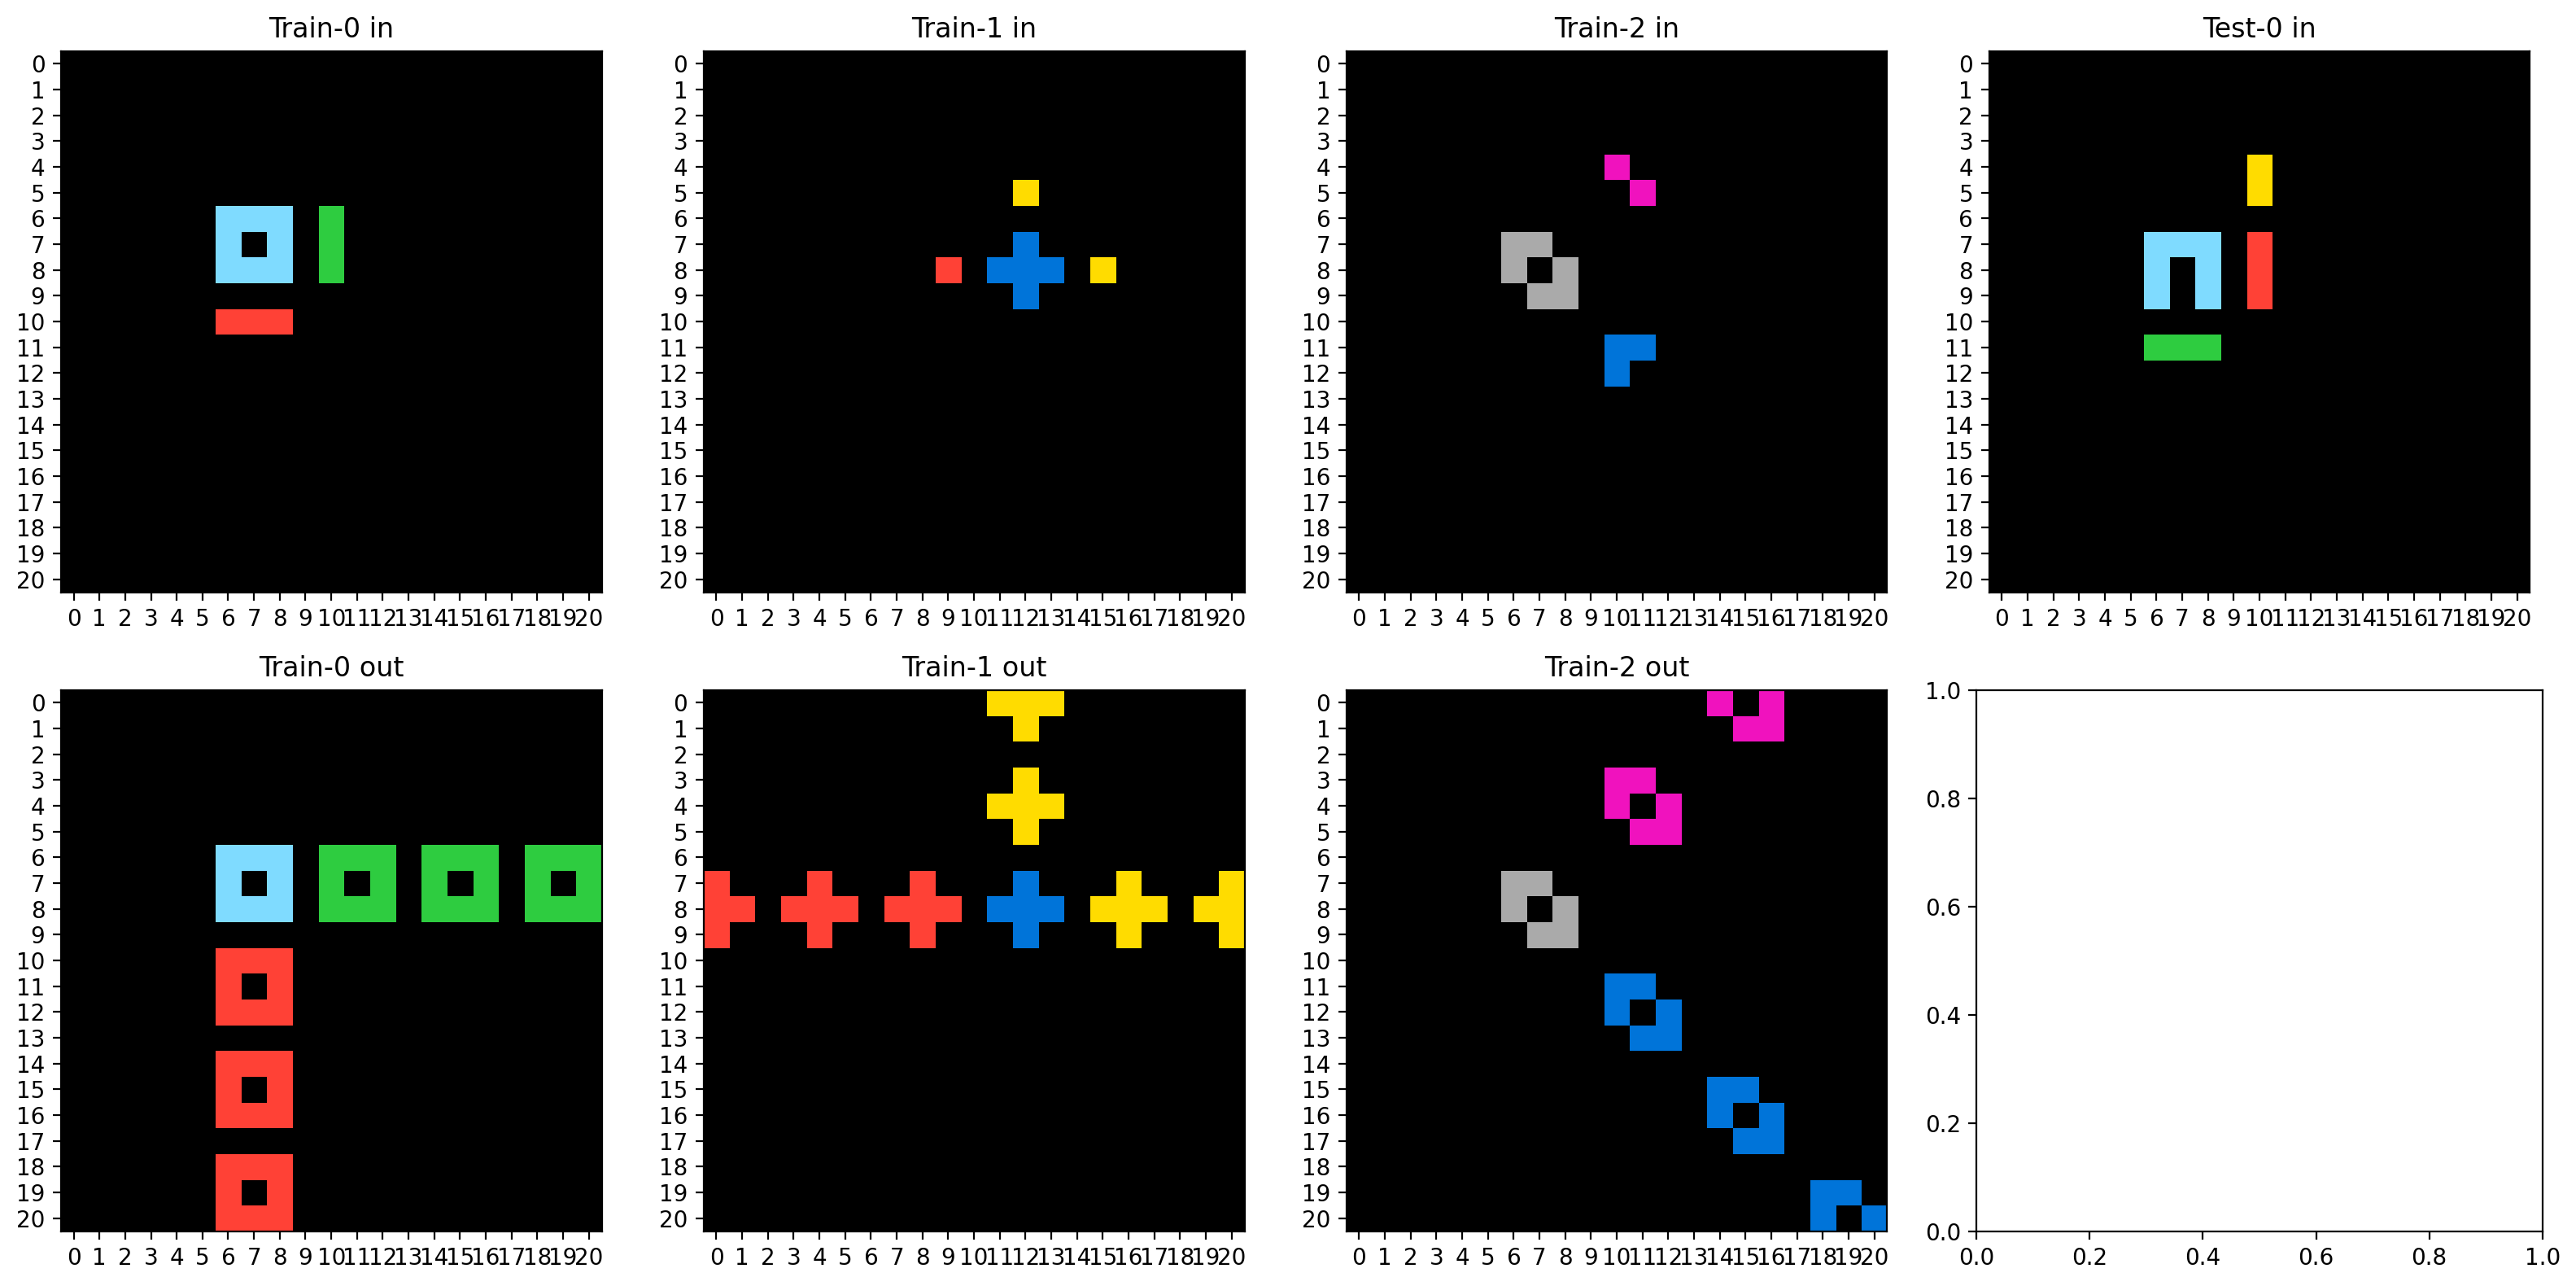

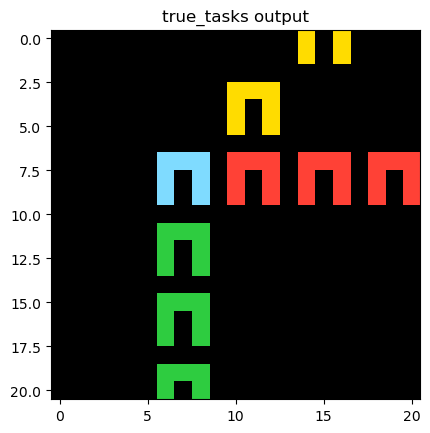

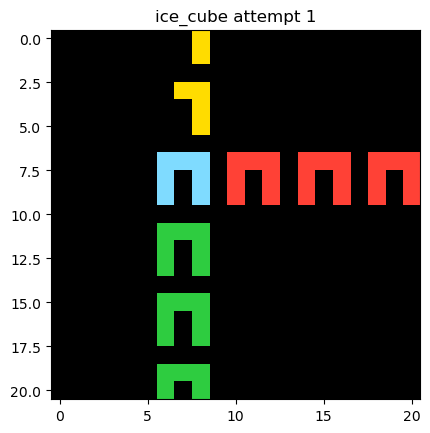

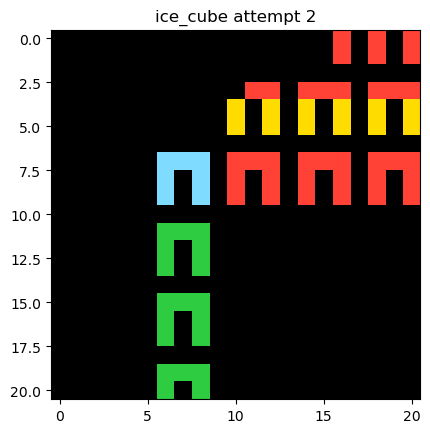

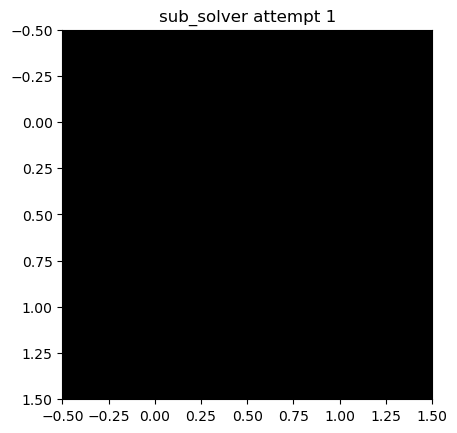

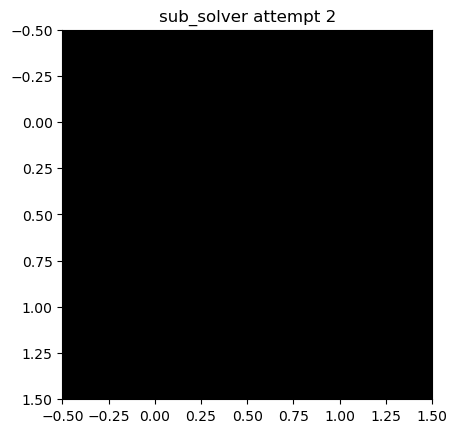

In [127]:
def display_unsolve_task(data_path, true_output_path, incorrect_list, task_index=None, icecube_output_path=None): 
    if icecube_output_path is not None:
        translate_submission(icecube_output_path)
        with open('./sub_icecube.json' , 'r') as f:
            sub_icecube = json.load(f)
    
    with open(data_path,'r') as f:
        tasks_name = list(json.load(f).keys())
    
    with open(data_path,'r') as f:
        tasks_file = list(json.load(f).values())
        
    with open(true_output_path,'r') as f:
        true_tasks_file = json.load(f)
        
    sub_solver = None
    with open('./sub_solver.json' , 'r') as f:
        sub_solver = json.load(f)
    
    if task_index is not None:
        task_name = incorrect_list[task_index]
        n = tasks_name.index(task_name)
        task = tasks_file[n]
        t = tasks_name[n]
        
        for i in range(len(task['test'])): 
           
            plot_task(task)
            
            # plot true output
            if true_output_path is not None:
                plt.title("true_tasks output")
                plot_pic(true_tasks_file[t][i])
            
            # # plot icecube output
            if icecube_output_path is not None and t in sub_icecube:
                plt.title("ice_cube attempt 1")
                plot_pic(sub_icecube[t][i]['attempt_1'])
                plt.title("ice_cube attempt 2")
                plot_pic(sub_icecube[t][i]['attempt_2'])
                
                
            if sub_solver is not None and t in sub_solver:
                plt.title("sub_solver attempt 1")
                plot_pic(sub_solver[t][i]['attempt_1'])
                plt.title("sub_solver attempt 2")
                plot_pic(sub_solver[t][i]['attempt_2'])
                
display_unsolve_task(train1_path, train2_path, incorrect_list, 7, train1_icecube_out)